In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
import seaborn as sns
import umap
import NaiveDE
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Import Morphological Features

In [2]:
# Import morphological features
df = pd.read_csv('../data/results/170315_161220_4_1/MorphologicalFeatures.csv', sep = ",")

img_shape = (22508, 33566)
img_shape = np.round(np.array(img_shape)/8).astype(np.int)

x_min = 0; x_max= img_shape[1];
y_min = 0; y_max= img_shape[0];
batch_size_px=16
overlap = 16


#Remove duplicates
df= df[df.Erase==False]
# Add Y Offset
df.Global_Y = df.Global_Y + 100
# Scale down coordinates for easer visualization
df["Global_X"]=df.Global_X/8
df["Global_Y"]=df.Global_Y/8

## Feature Preprocessing

In [3]:
# Extract relevant features
feature_list = ['Global_Y', 'Global_X','Nuclei_AreaShape_Compactness', 'Nuclei_AreaShape_Eccentricity', 'Nuclei_AreaShape_Extent', 'Nuclei_AreaShape_FormFactor', 'Nuclei_AreaShape_Solidity', 'Nuclei_Intensity_IntegratedIntensity_DNA', 'Nuclei_Intensity_LowerQuartileIntensity_DNA', 'Nuclei_Intensity_MADIntensity_DNA', 'Nuclei_Intensity_MeanIntensity_DNA', 'Nuclei_Intensity_StdIntensity_DNA', 'Nuclei_Neighbors_FirstClosestDistance_10', 'Nuclei_Neighbors_NumberOfNeighbors_10', 'Nuclei_Neighbors_PercentTouching_10', 'Nuclei_Neighbors_SecondClosestDistance_10', 'Nuclei_RadialDistribution_FracAtD_CorrBlue_1of4', 'Nuclei_RadialDistribution_FracAtD_CorrBlue_2of4']
df = df.loc[:,feature_list]

# Remove outliers due to failiurs in segmentation
df = df[(df.Nuclei_AreaShape_Compactness>=1) & (df.Nuclei_AreaShape_Compactness<=1.5)]

# Clip values feature values
feature_lower_bounds = [1, 0, 0.5, 0.2, 0.75, 4, 0.01, 0.001, 0.02, 0.002, 20, 0, 0, 0, 0.02, 0.1]
feature_upper_bounds = [1.5, 1, 0.7, 0.6, 0.9, 44, 0.015, 0.009, 0.03, 0.015, 70, 2.5, 70, 100, 0.09, 0.25]
df.iloc[:,2:] = df.iloc[:,2:].clip(lower=feature_lower_bounds, upper= feature_upper_bounds , axis=1)

# Scale each faeture to [0,1]
df.iloc[:,2:] = (df.iloc[:,2:]-df.iloc[:,2:].min())/(df.iloc[:,2:].max()-df.iloc[:,2:].min())

## Generate Morphology Matrix

In [ ]:
tot_cells = []
morphology_table = pd.DataFrame(data={}, columns=df.columns[2::], index=list((str(x)+"x"+str(y)) for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px))) 
for i in tqdm(range(x_min,x_max,batch_size_px)):
    for j in range(y_min,y_max,batch_size_px):
        batch_df=df[(df.Global_X>=i-(batch_size_px/2)-overlap) & (df.Global_X<i+(batch_size_px/2)+overlap) & (df.Global_Y>=j-(batch_size_px/2)-overlap) & (df.Global_Y<j+(batch_size_px/2)+overlap)].iloc[:,2::]
        if len(batch_df):
            batch_counts = batch_df.sum()
            morphology_table.loc[str(i)+'x'+str(j),batch_counts.index]=batch_counts
            morphology_table.loc[str(i)+'x'+str(j),'tot_count'] = batch_df.shape[0]
morphology_table = morphology_table.fillna(0)

# Save Morphology Matrix
morphology_table.to_pickle('../data/results/170315_161220_4_1/morphology_table.hdf5')

In [4]:
# Load Morphology Matrix
morphology_table = pd.read_pickle('../data/results/170315_161220_4_1/morphology_table.hdf5')

In [5]:
# Create sample_info
sample_info = pd.DataFrame(data={'x':list(x for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px)), 'y':list(y for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px))}, index=list((str(x)+"x"+str(y)) for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px)))
sample_info['total_counts'] = morphology_table.tot_count
# Dropping empty batches (with less then 3 cells)
morphology_table = morphology_table[sample_info.total_counts>3]
sample_info = sample_info[sample_info.total_counts>3]

morphology_table.drop(['tot_count'], axis=1, inplace=True)

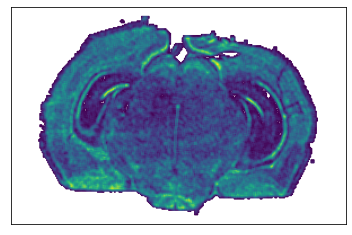

In [6]:
plt.figure(); plt.scatter(sample_info['x'], sample_info['y'], c=sample_info['total_counts'], s=1);
plt.xticks([])
plt.yticks([]);
plt.axis('equal');

## Normalize Morphology Matrix

In [7]:
# Linear regression to account tot number of cells in each patch
resid_expr = NaiveDE.regress_out(sample_info, morphology_table.T, 'total_counts').T
idx = resid_expr.var().sort_values(ascending=False).index

## Visualize Morpholofical Features

In [13]:
idx = resid_expr.var().sort_values(ascending=False).index
reducer = umap.UMAP(
        n_neighbors=10,
        min_dist=0.5,
        n_components=3,
        metric='cosine',
        random_state=42,
        init='spectral')
Y_umap = reducer.fit_transform(scale(resid_expr[idx],1))
Y = Y_umap
sample_info['Y']=[x.reshape(1,len(x)) for x in Y]
Y -= np.min(Y, axis=0)
Y /= np.max(Y, axis=0)

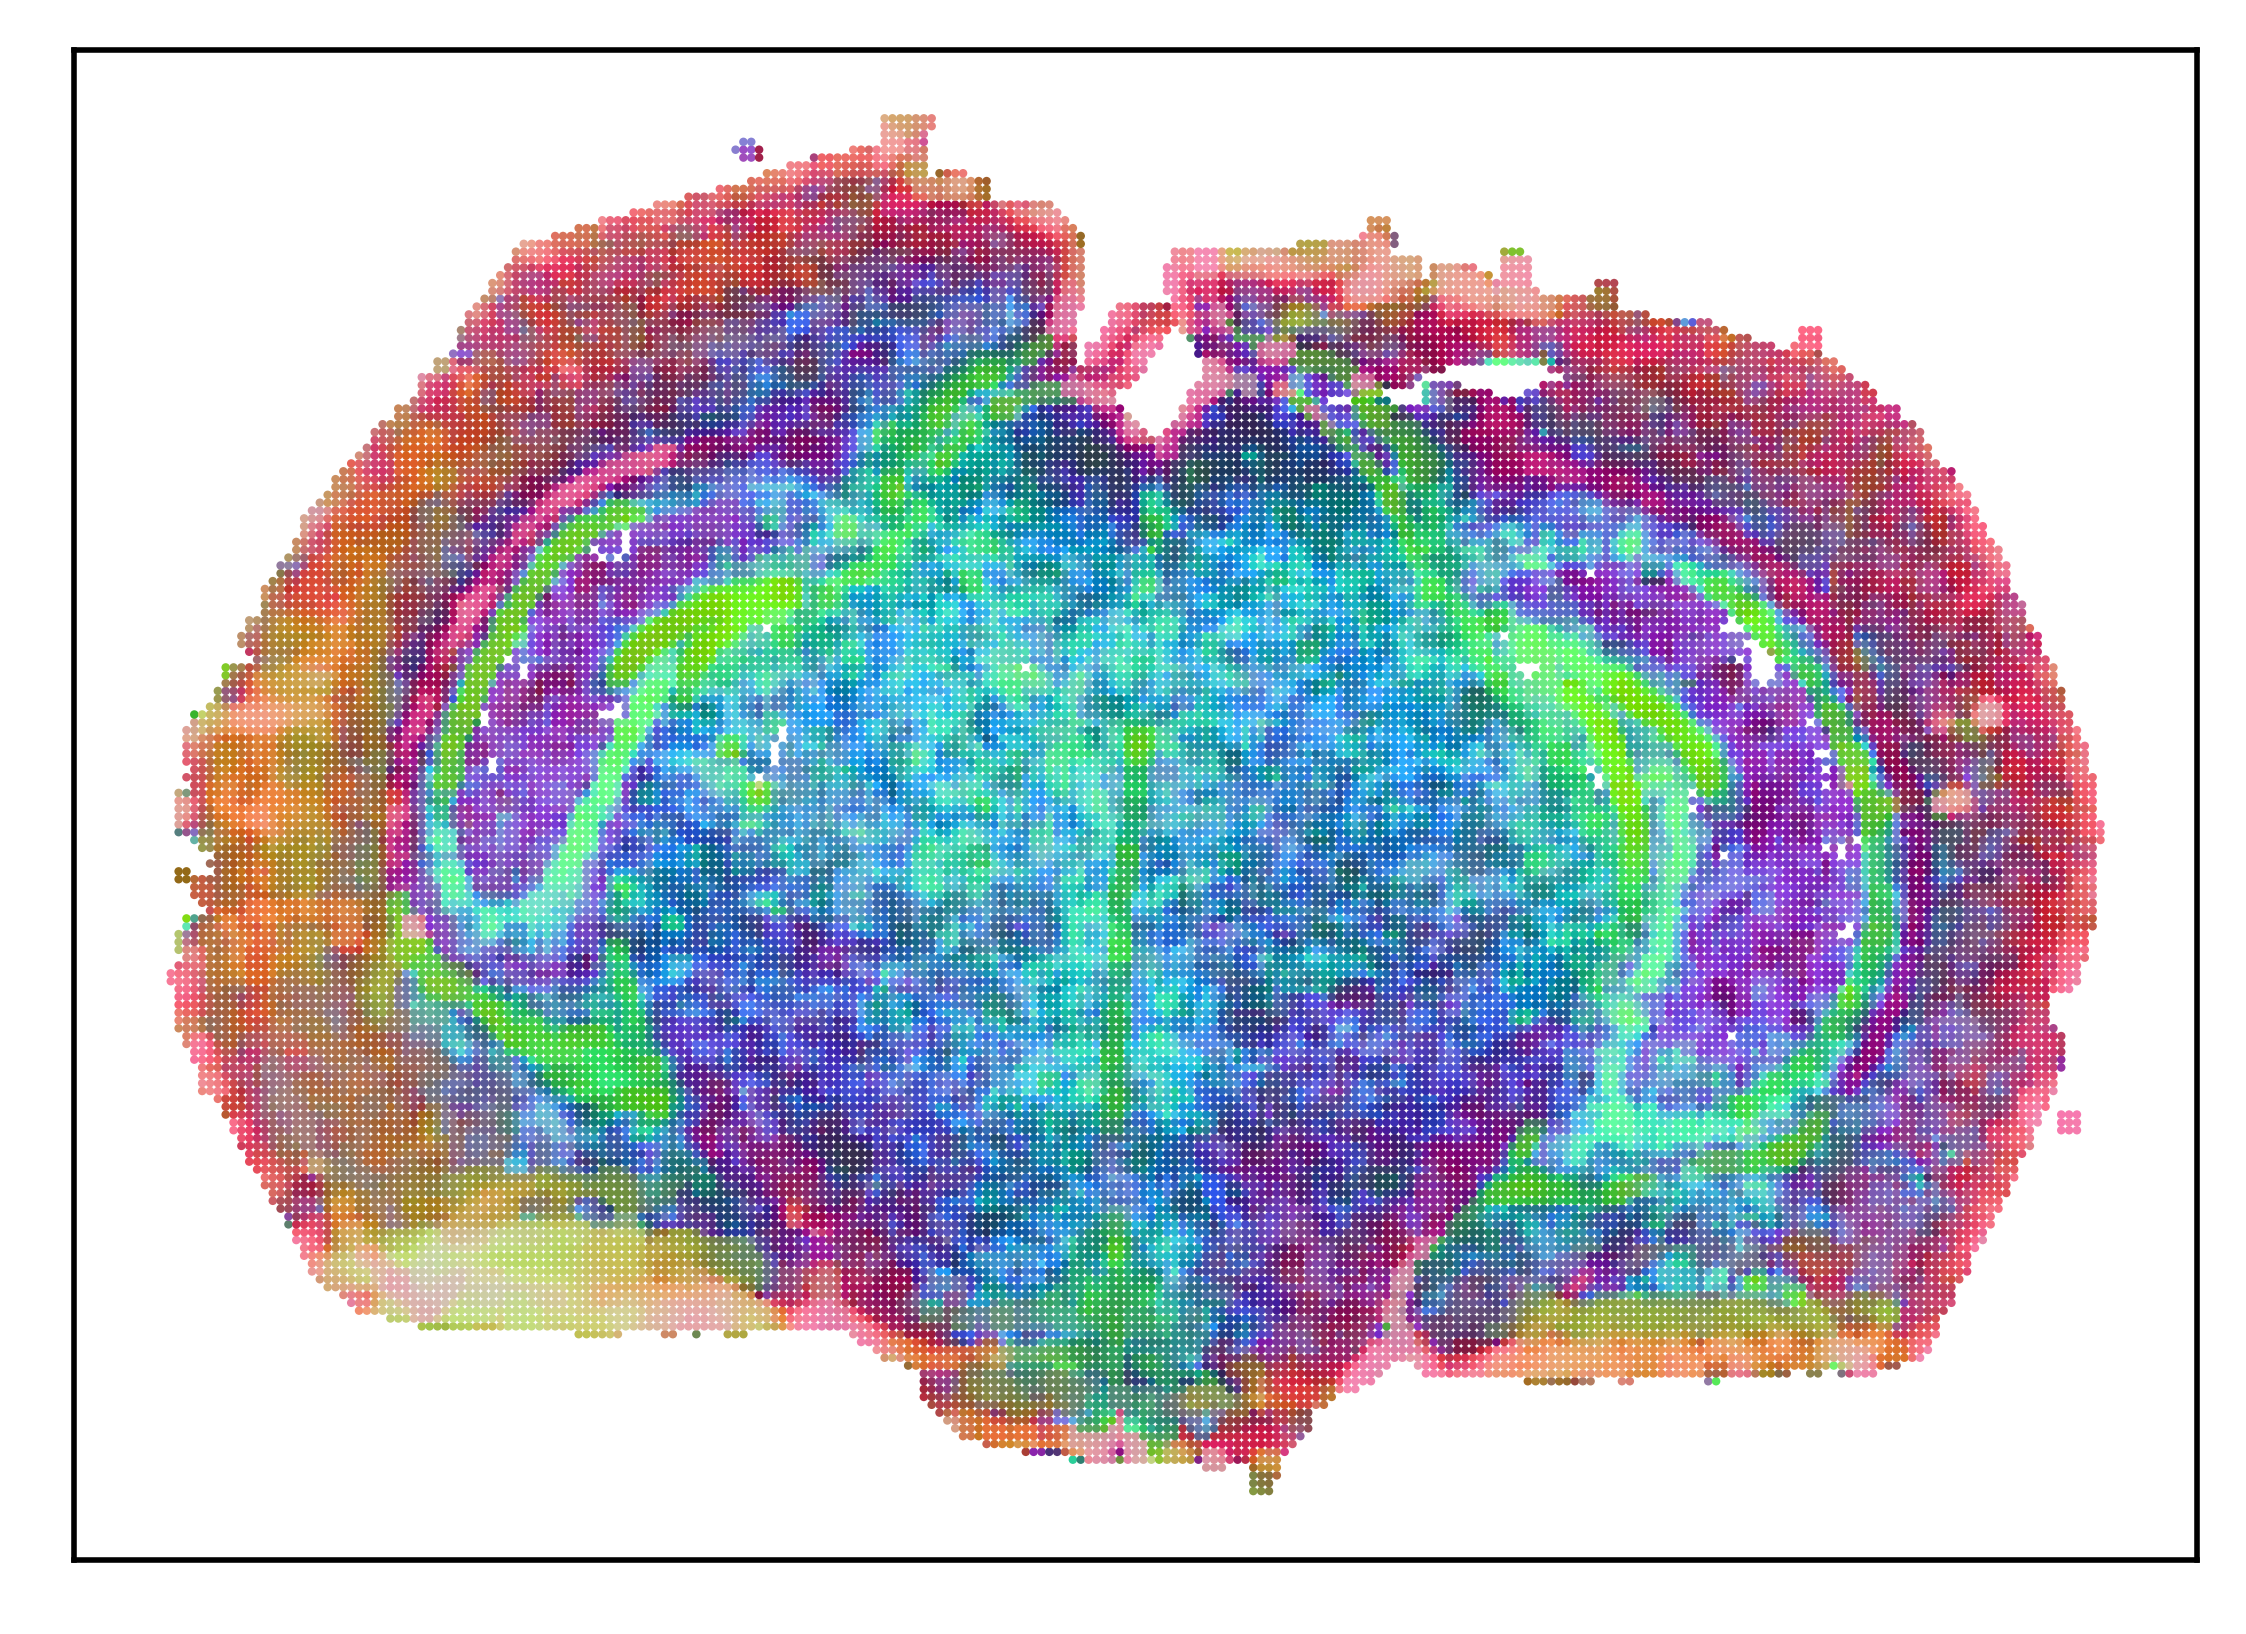

In [14]:
fig=plt.figure(dpi=500)
plt.scatter(sample_info.x, sample_info.y, c=Y, s=1.5, linewidths=0, rasterized=True);
plt.xticks([])
plt.yticks([]);
plt.axis('scaled');

# fig.savefig('../figures/continuum-morphology.svg', dpi=600)

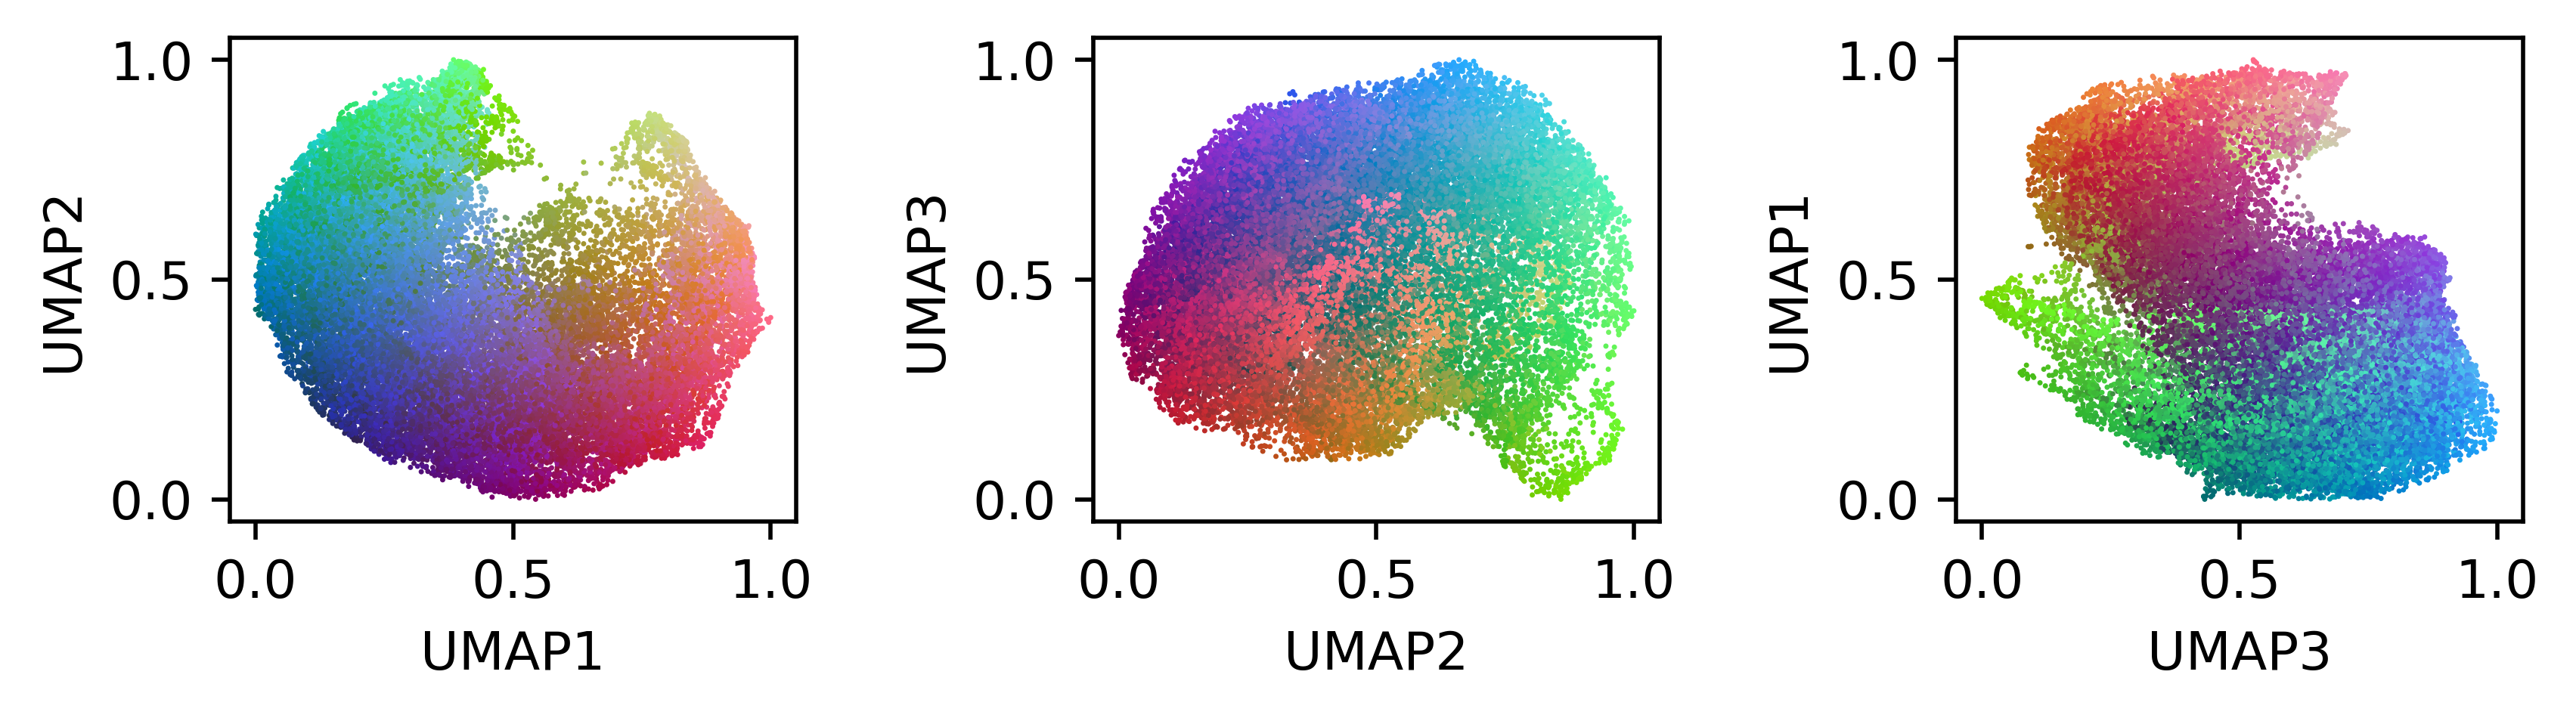

In [15]:
fig=plt.figure(figsize=(7,2),dpi=500)
cycled = [0,1,2,0]
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(Y[:,cycled[i]], Y[:,cycled[i+1]], c=Y,s=1, linewidths=0)
    plt.xlabel("UMAP"+str(cycled[i]+1))
    plt.ylabel("UMAP"+str(cycled[i+1]+1))

plt.tight_layout()       
# fig.savefig('../figures/continuum-morphology_b.png')

## Extract Morphological Features from Gene Expression Clusters

In [16]:
sample_df = pd.read_csv('../data/results/sample_info.csv',  index_col=0)
sample_df = sample_df[sample_df.s==0]
sample_df.index = sample_df.index.to_series().str.split("_").str[0]

sample_df = sample_df.drop(sample_df.index.difference(resid_expr.index))
resid_expr = resid_expr.drop(resid_expr.index.difference(sample_df.index))
morphology_table = morphology_table.drop(morphology_table.index.difference(sample_df.index))
pos_res_exp = resid_expr - resid_expr.min().min()

In [17]:
sample_df.top_cluster.unique().shape

(14,)

In [18]:
# Clusters Morphological Features Table
clusters=[]
for c in np.unique(sample_df.loc[:,'top_cluster']):
    clusters.append(pos_res_exp.loc[sample_df[sample_df.top_cluster==c].index,:])

cluster_exp_tab = np.zeros((len(np.unique(sample_df.loc[:,'top_cluster'])),len(pos_res_exp.columns.values)))

for c, cluster in enumerate(np.unique(sample_df.loc[:,'top_cluster'])):
    for g, gene in enumerate(pos_res_exp.columns.values):
        # Normalizationtion by cluster area
        cluster_exp_tab[c,g] = clusters[c].loc[:,gene].sum()/len(clusters[c])

# Normalize by feature (column)
cluster_exp_tab=cluster_exp_tab/cluster_exp_tab.sum(axis=0)[None,:]
cluster_exp_tab = pd.DataFrame(cluster_exp_tab,columns=pos_res_exp.columns, index=np.unique(sample_df.loc[:,'top_cluster']))

def get_label(x):
    c_label = [chr(x) for x in range(65,91)]
    return c_label[int(x)]

cluster_exp_tab.index = cluster_exp_tab.index.to_series().apply(get_label)

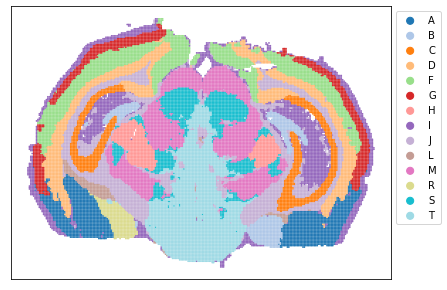

In [19]:
# Plot spatial compartments (identified by gene expression)
from cycler import cycler
import matplotlib as mpl
from matplotlib.colors import to_rgb
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#1f77b4","#aec7e8","#ff7f0e","#ffbb78","#2ca02c","#98df8a","#d62728","#ff9896","#9467bd","#c5b0d5","#8c564b","#c49c94","#e377c2","#f7b6d2","#7f7f7f","#c7c7c7","#bcbd22","#dbdb8d","#17becf","#9edae5"])
c_list=["#1f77b4","#aec7e8","#ff7f0e","#ffbb78","#2ca02c","#98df8a","#d62728","#ff9896","#9467bd","#c5b0d5","#8c564b","#c49c94","#e377c2","#f7b6d2","#7f7f7f","#c7c7c7","#bcbd22","#dbdb8d","#17becf","#9edae5"]

plt.figure(figsize=(15,20))
plt.subplot(1,2,1)
c_label = [chr(x) for x in range(65,91)]
for i, g in sample_df.loc[sample_df.s==0,:].groupby('top_cluster'):
    plt.scatter(g.x, g.y, label=c_label[int(i)], c=np.array([np.array(to_rgb(c_list[int(i)])),]*len(g.x)), s=0.5)
plt.xticks([])
plt.yticks([]);
plt.axis('scaled');
plt.legend(bbox_to_anchor=(1, 1),loc=2, markerscale=10)

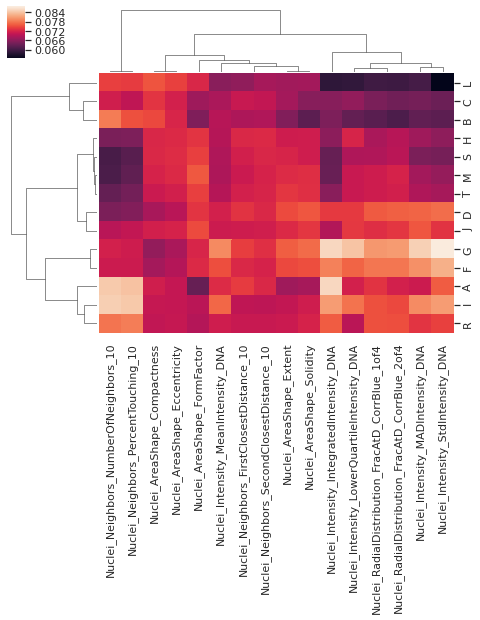

In [20]:
# Plot clustermap
sns.set(font_scale = 1)
g=sns.clustermap(cluster_exp_tab.loc[[get_label(int(x)) for x in sample_df.loc[sample_df.s==0,'top_cluster'].unique().tolist()],:],xticklabels=True, yticklabels=True, metric='cosine', figsize=(8,6))
# g.savefig('../figures/morphology-heatmap.pdf')

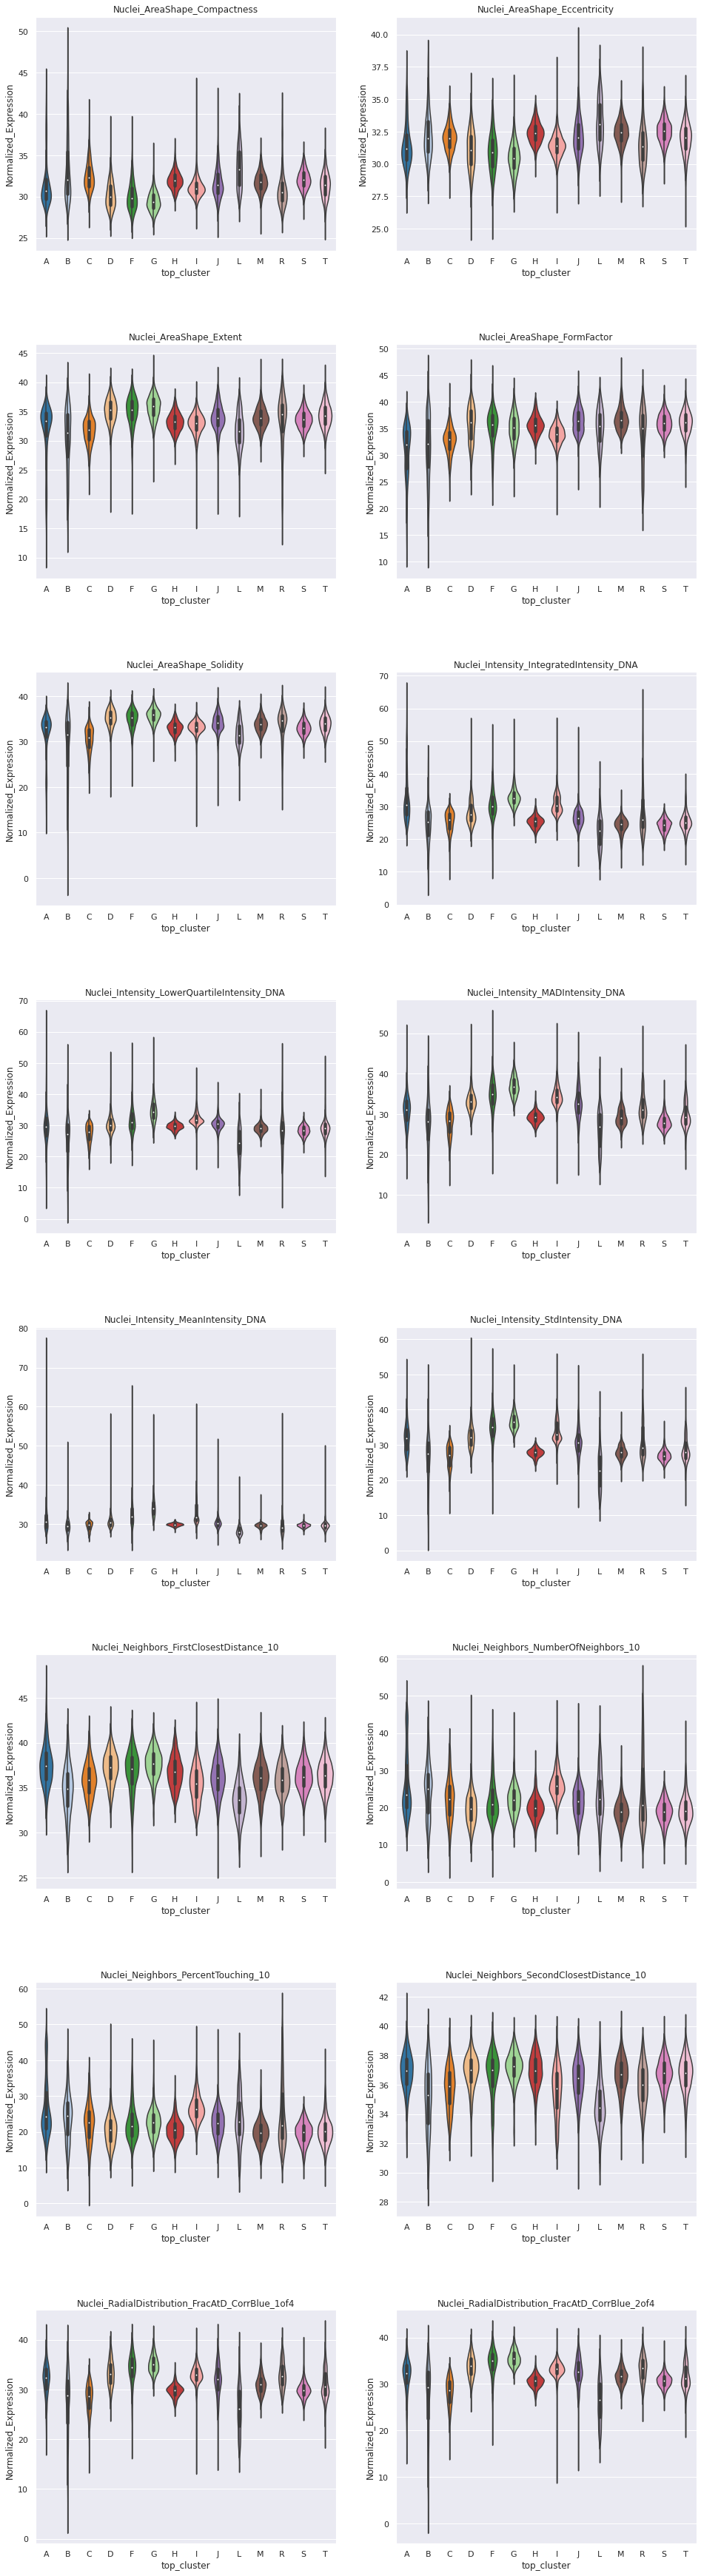

In [21]:
def get_label(x):
    c_label = [chr(x) for x in range(65,91)]
    return c_label[x]


idx=[x for x in pos_res_exp.columns]
c_list=["#1f77b4","#aec7e8","#ff7f0e","#ffbb78","#2ca02c","#98df8a","#d62728","#ff9896","#9467bd","#c5b0d5","#8c564b","#c49c94","#e377c2","#f7b6d2","#7f7f7f","#c7c7c7","#bcbd22","#dbdb8d","#17becf","#9edae5"]

plt.figure(figsize=(16,128))
for i,gene in enumerate(idx):
    gene_exp = pd.DataFrame({'Normalized_Expression':pos_res_exp.loc[:,gene], 's':sample_df.s, 'top_cluster':sample_df.top_cluster.astype(np.uint).apply(get_label)})
    plt.subplot(len(idx),2,i+1)
    ax = sns.violinplot(x="top_cluster", y="Normalized_Expression", data=gene_exp, palette=c_list, order=np.sort(gene_exp.top_cluster.unique()))
    plt.title(gene)
    plt.subplots_adjust(hspace=0.4)